In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import io
from scipy.linalg import fractional_matrix_power
from fcmeans import FCM
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('indivs_Georgia20.csv')
# Pick out each unique transaction pair and filter to those with larger total donation
grouped_df = df.groupby(['Recipid', 'Contribid']).agg(num_rows=('Amount', 'count'), total_amount=('Amount', 'sum')).reset_index()
filtered_df = grouped_df[(grouped_df['total_amount'] >= 2000)]

# Filter out contributors that only donated once
contribid_counts = grouped_df['Contribid'].value_counts()
non_unique = contribid_counts[contribid_counts > 1].index
filtered_df = filtered_df[filtered_df['Contribid'].isin(non_unique)]

# Filter out recipients that only recieved one donation
recipid_counts = grouped_df['Recipid'].value_counts()
non_unique1 = recipid_counts[recipid_counts > 1].index
filtered_df = filtered_df[filtered_df['Recipid'].isin(non_unique1)]

#Remove blank recipids
filtered_df['Recipid'] = filtered_df['Recipid'].astype(str)
filtered_df['Recipid'] = filtered_df['Recipid'].str.strip()
filtered_df = filtered_df.replace('', np.nan)
filtered_df = filtered_df[filtered_df['Recipid'].notnull()]

#Remove blank contribids
filtered_df['Contribid'] = filtered_df['Contribid'].astype(str)
filtered_df['Contribid'] = filtered_df['Contribid'].str.strip()
filtered_df = filtered_df.replace('', np.nan)
filtered_df = filtered_df[filtered_df['Contribid'].notnull()]

C:\Users\qi\AppData\Local\Temp\ipykernel_4556\2472486244.py:1: DtypeWarning: Columns (6,10,13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('indivs_Georgia20.csv')


In [ ]:
#Create an undirected network based on the transactions
G = nx.from_pandas_edgelist(filtered_df, source='Contribid', target='Recipid', create_using=nx.DiGraph)
undir = G.to_undirected(as_view=True)
adj_matrix = nx.to_numpy_array(undir)

In [ ]:
#Check the number of nodes
print(len(adj_matrix))

11975


In [ ]:
#Get eigenvalues for spectral characterization
ceigenvalues, _ = np.linalg.eig(adj_matrix)
eigenvalues = np.real(ceigenvalues)
imaginary = np.imag(ceigenvalues)
print("Eigenvalues of the adjacency matrix:")
print(eigenvalues)

[77.56592823178107, 42.83540251215805, 41.17751869650596, 39.575419667917394, 25.503975875900014, 25.037444366402873, 22.789929946285067, 20.31020086802794, 19.23036877251094, 18.332158378010547, 18.198676537836818, 15.722926391956024, 15.539211401683131, 15.025320879933785, 14.837291004520303, 14.7601580923422, 13.407257878024257, 13.254098250801299, 13.22020498216154, 13.037751850208187, 12.781880254078594, 12.486473989428644, 12.583194381537501, 11.977015875836063, 11.002018159262402, 10.403389618506415, 10.36565773085877, 10.283560276726588, 10.088125687251255, 9.900537509286618, 9.625868591793154, 9.479298699937436, 9.386383427697847, 9.275460841758495, 8.979887634044053, 8.828333652113278, 8.765392591690977, 8.667245494155145, 8.58003651923521, 8.48751386411637, 8.422112399466332, 8.198929206455798]


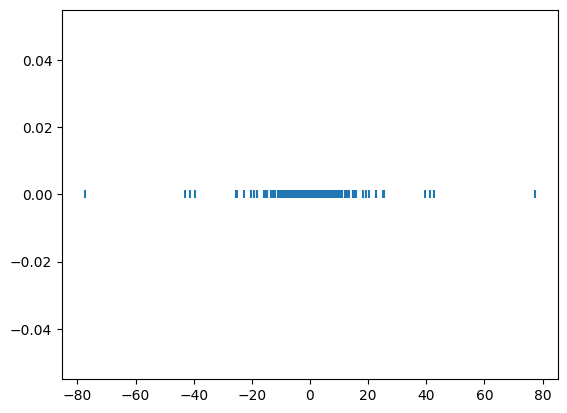

In [ ]:
#Plot results to determine hierarchy
z = np.zeros(len(eigenvalues))
filtered = [eigenvalue for eigenvalue in eigenvalues if eigenvalue > 8]
print(filtered)
plt.scatter(eigenvalues, z, marker='|')
plt.show()

In [ ]:
#Set hierarchy cluster numbers
clusters = [2,4,6]

In [ ]:
#Get eigenvalues of Laplacian matrix
A = adj_matrix
D = np.diag(np.sum(A, axis=1))
D_sqrt_inv = fractional_matrix_power(D, -0.5)
L = np.dot(np.dot(D_sqrt_inv, A), D_sqrt_inv)
eigenvaluesL, eigenvectorsL = np.linalg.eigh(L)

In [ ]:
def largest_eigenvectors(L, k):
    indices = eigenvaluesL.argsort()[::-1][:k]
    return eigenvectorsL[:, indices]

def renormalize_matrix(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    zero_norms = norms == 0.0
    norms[zero_norms] = 1.0
    Y = X / norms
    return Y

def clustering(k):
    X = largest_eigenvectors(L, k)
    Y = renormalize_matrix(X)
    fcm = FCM(n_clusters=k)
    fcm.fit(Y)
    fcm_soft_labels = fcm.soft_predict(Y)
    fcm_labels = fcm.predict(Y)
    return fcm_labels, fcm_soft_labels

In [ ]:
#Cluster at each hierarchy level and record results in a dictionary
res = {'id': list(G.nodes())}
for k in clusters:
    hard, soft = clustering(k)
    res['hard'+str(k)] = hard
    soft = np.array(soft)
    soft = soft.transpose()
    for i in range(k):
        res['soft'+str(k)+"_"+str(i)] = soft[i]

In [ ]:
#Make a dataframe from the dictionary
fdf = pd.DataFrame(res)

In [ ]:
fdf

,id,hard2,soft2_0,soft2_1,hard4,soft4_0,soft4_1,soft4_2,soft4_3,hard6,soft6_0,soft6_1,soft6_2,soft6_3,soft6_4,soft6_5
0,c0060033746,1,0.045008,0.954992,0,0.935085,0.014121,0.026649,0.024145,2,0.000928,0.006579,0.976218,0.000818,0.014778,0.000679
1,C00000422,1,0.045008,0.954992,0,0.935085,0.014121,0.026649,0.024145,2,0.000928,0.006579,0.976218,0.000818,0.014778,0.000679
2,d0000689706,0,0.906719,0.093281,2,0.177418,0.311691,0.330093,0.180798,1,0.093863,0.281399,0.206833,0.105239,0.233394,0.079271
3,h1001311865,1,0.170867,0.829133,3,0.283358,0.195269,0.174775,0.346598,4,0.074837,0.160465,0.300085,0.056432,0.356649,0.051531
4,d0000792527,1,0.202818,0.797182,0,0.542131,0.091823,0.266822,0.099224,5,0.001786,0.000182,0.000143,0.002100,0.000208,0.995581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11970,r0014650650,0,0.880263,0.119737,1,0.048942,0.734726,0.087792,0.128540,5,0.179847,0.021386,0.016441,0.177099,0.022964,0.582263
11971,r0015377044,0,0.893148,0.106852,1,0.046558,0.753105,0.087278,0.113059,5,0.151479,0.018100,0.013895,0.163633,0.019511,0.633382
11972,r0025253382,0,0.893248,0.106752,1,0.064040,0.672332,0.116105,0.147524,5,0.182124,0.022820,0.017461,0.189683,0.024320,0.563590
11973,N00047441,1,0.015248,0.984752,0,0.782221,0.046483,0.068625,0.102671,4,0.026981,0.090692,0.373252,0.022164,0.467638,0.019273


In [ ]:
#Export results as a csv
fdf.to_csv('2,4round2.csv')

In [ ]:
#Compare the similarity of different clusters to find connect parents with children
def jaccard(labelsA, labelsB, a, b):
  matrix = np.zeros((a,b))
  for i in range(a):
    for j in range(b):
      intersection = 0
      union = 0
      for k in range(len(labelsA)):
        hitA = labelsA[k] == i
        hitB = labelsB[k] == j
        if hitA or hitB:
          union += 1
        if hitA and hitB:
          intersection += 1
      matrix[i][j] = intersection / union
  return matrix

In [ ]:
for i in range(len(clusters)-1):
    print(jaccard(res['hard'+str(clusters[i])], res['hard'+str(clusters[i+1])], clusters[i], clusters[i+1]))

[[0.00000000e+00 4.25699301e-01 1.60519409e-01 3.52510808e-01]
 [7.08852669e-01 3.45105257e-04 2.05121294e-01 3.54499881e-02]]
[[9.69959647e-02 7.97045101e-02 0.00000000e+00 5.22330719e-01
  1.54888674e-02 6.49226656e-03]
 [1.60547469e-01 3.43222804e-02 1.82549903e-01 1.18689501e-01
  2.36443884e-02 4.53529224e-02]
 [2.20353789e-01 1.71287739e-01 0.00000000e+00 6.39056500e-02
  2.29929577e-01 0.00000000e+00]
 [1.05317823e-01 9.71151100e-03 2.23860590e-01 7.89284171e-02
  3.10077519e-04 2.54145777e-01]]
